In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.info()
print("-" * 40)
train_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------


(891, 12)

In [5]:
test_data.info()
print("*" * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass   

## Noticed that there are 4 categories conataining missing values
1. If the dataset is large with only few missing values, you can delete the rows with missing values;
2. If the attribute is not important relative to learning, the missing value can be assigned a mean or mode. 
+ For example, the attribute Embarked (there are three embarkation locations) is missing two values and can be assigned by the mode
3. For nominal attributes, you can assign a value that represents the missing, such as 'U0'. Because the absence itself may also represent some implicit information. 
+ For example, the attribute of cabin number Cabin, the absence may mean that there is no cabin.
4. Use models such as regression random forest to predict the value of missing attributes. 
+ Because Age is a very important feature in this data set (you can know it by analyzing Age first), it is very important to ensure a certain filling accuracy of missing values, which will also have a great impact on the results. In general, data-complete entries are used as the training set of the model to predict missing values. For the current data, random forest can be used to predict or linear regression can be used to predict.



In [6]:
# Use mode to predict missing values in Embarked\
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

In [7]:
# Use "U0" to mark missing cabin
train_data['Cabin'] = train_data.Cabin.fillna("U0")

In [8]:
#use one hot to encode features
age_data = train_data[['Age', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']]
sex_one_hot = pd.get_dummies(age_data.Sex)
age_data = age_data.drop('Sex', axis=1).join(sex_one_hot)
embarked_one_hot = pd.get_dummies(age_data.Embarked)
age_data = age_data.drop('Embarked', axis=1).join(embarked_one_hot)
age_data.head()

# Split none null value
age_data_isnull = age_data.loc[(train_data.Age.isnull())]
age_data_notnull = age_data.loc[(train_data.Age.notnull())]

age_data_notnull.head()

,Age,Survived,Pclass,SibSp,Parch,Fare,female,male,C,Q,S
0,22.0,0,3,1,0,7.2500,0,1,0,0,1
1,38.0,1,1,1,0,71.2833,1,0,1,0,0
2,26.0,1,3,0,0,7.9250,1,0,0,0,1
3,35.0,1,1,1,0,53.1000,1,0,0,0,1
4,35.0,0,3,0,0,8.0500,0,1,0,0,1


In [9]:
# Use random forest to predict age
from sklearn.ensemble import RandomForestRegressor

# Make X,Y
X = age_data_notnull.values[:, 1:]
Y = age_data_notnull.values[:, 0]

# fit random forest
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=1)
RFR.fit(X,Y)
predict = RFR.predict(age_data_isnull.values[:, 1:])
train_data.loc[(train_data['Age'].isnull()), ['Age']] = predict

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Overview of the survived rate in training set

<Axes: ylabel='Survived'>

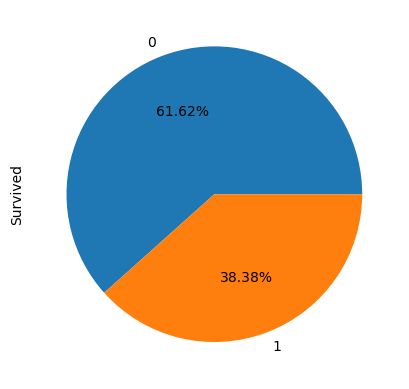

In [10]:
train_data['Survived'].value_counts().plot.pie(autopct="%1.2f%%")

## check relationship between Sex and Survived

<Axes: xlabel='Sex'>

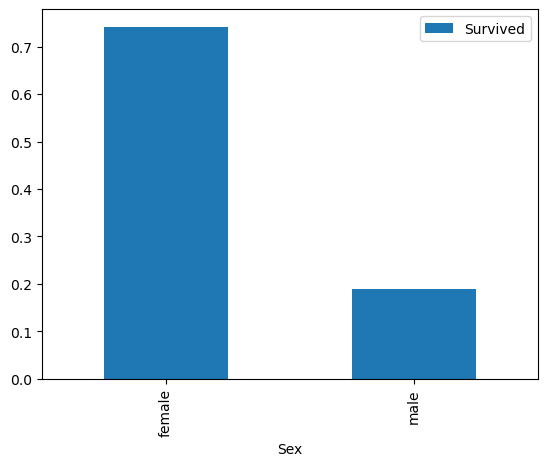

In [11]:
train_data.groupby(by=['Sex', 'Survived'])['Survived'].count()
train_data[['Sex', 'Survived']].groupby(by='Sex').mean().plot.bar()

## check relationship between Sex and Survived

<Axes: xlabel='Pclass'>

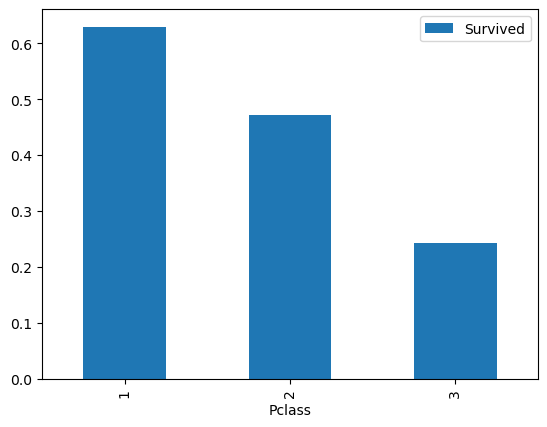

In [12]:
train_data[['Pclass', 'Survived']].groupby('Pclass').mean().plot.bar()

## Overview, that female has higher prob. although Pclass has slight effect as well

<Axes: xlabel='Pclass,Sex'>

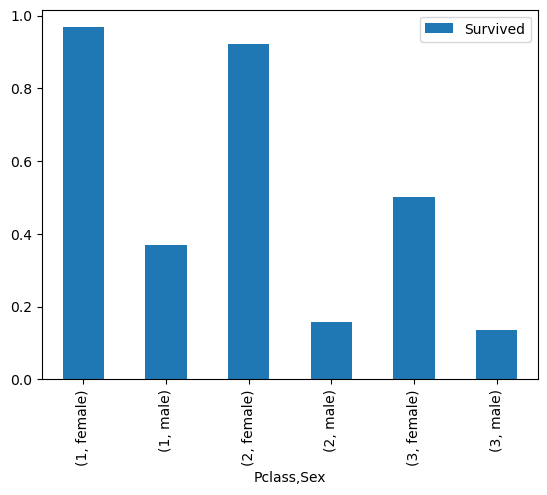

In [13]:
train_data[['Pclass', 'Sex', 'Survived']].groupby(['Pclass', 'Sex']).mean().plot.bar()

## Pclass, age and survived

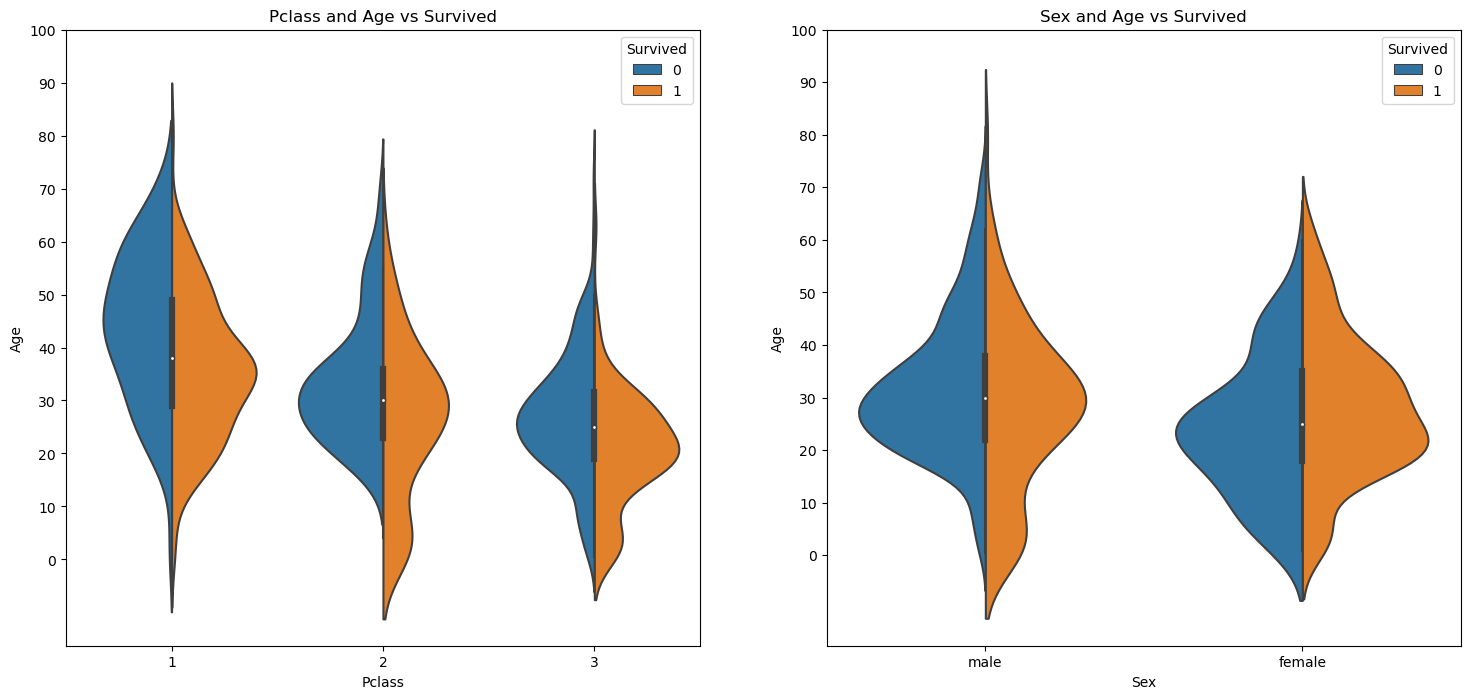

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train_data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot(x="Sex", y="Age", hue="Survived", data=train_data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

## Overview of age distribution

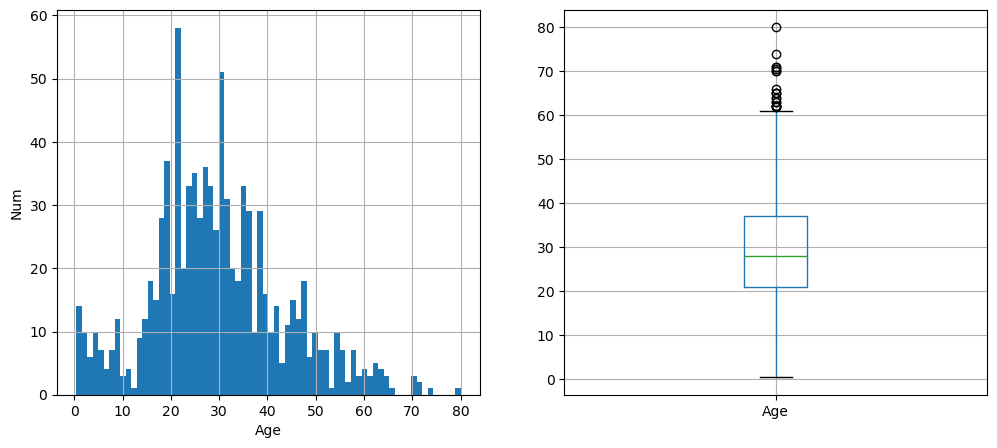

count    891.000000
mean      29.644477
std       13.837355
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(121) # 示将图表分成1行2列，并使用第1个位置
train_data['Age'].hist(bins=70) #分成70个range
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122) #使用第二个位置
train_data.boxplot(column='Age') #绘制箱线图，不显示离群值
plt.show()
train_data['Age'].describe()

## Overview of age and survived

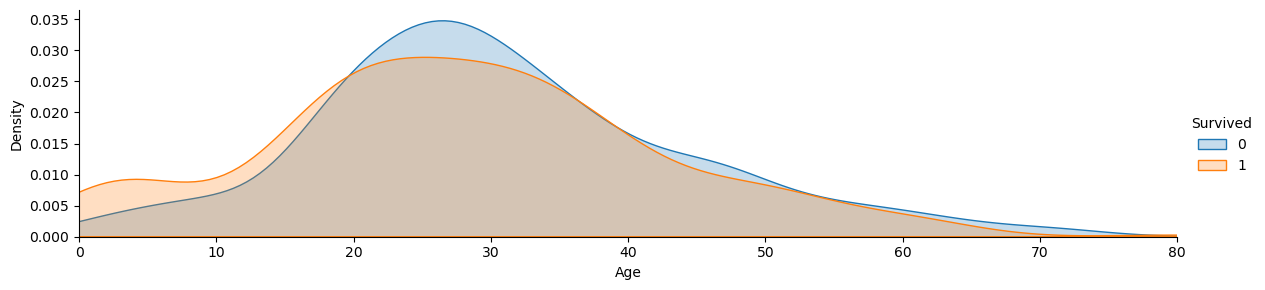

In [16]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4) #创建多面版图，针对Survived进行分组，图的宽高比为4
facet.map(sns.kdeplot,'Age',shade= True) #将核密度图(KDE)应用到Age上，并对曲线下进行填充
facet.set(xlim=(0, train_data['Age'].max())) #设置x的最大最小值
facet.add_legend() # 添加图例

## Rate of survival of different ages

<Axes: xlabel='Age_int', ylabel='Survived'>

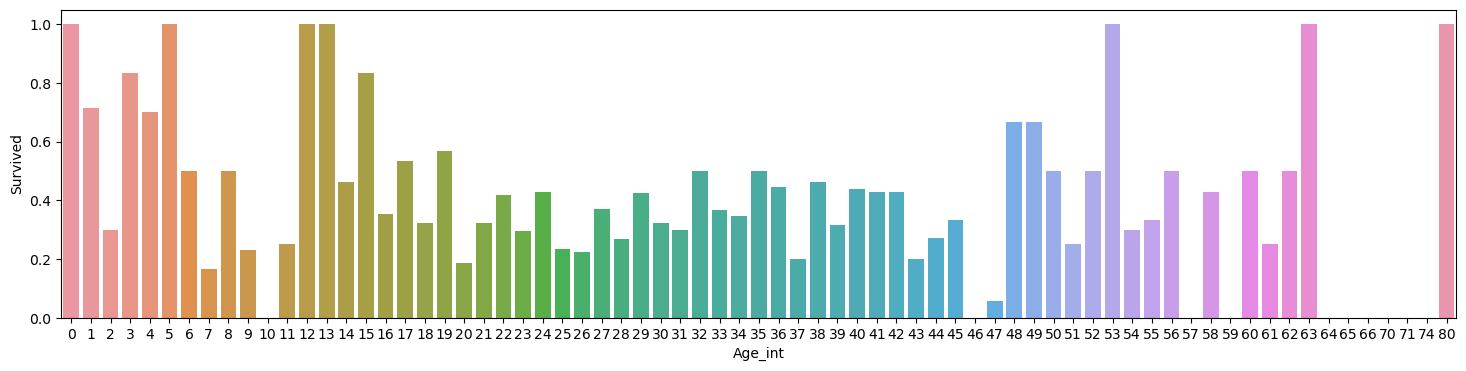

In [17]:
fig, axis1 = plt.subplots(1, 1, figsize=(18,4))
train_data["Age_int"] = train_data["Age"].astype(int)
average_age = train_data[["Age_int", "Survived"]].groupby("Age_int",as_index=False).mean() #不把Age_int当成索引而是作为特征
sns.barplot(x="Age_int", y = "Survived", data=average_age) #sns.barplot只能使用普通列而不是index列来作为x轴

## Split the ages into groups

<Axes: xlabel='Age_group'>

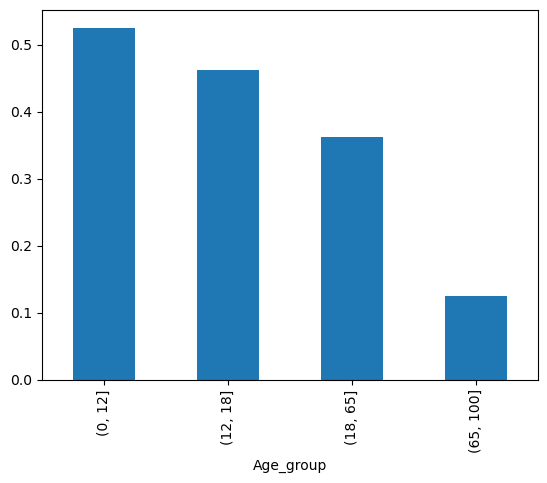

In [18]:
bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'], bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age.plot.bar()

## Title with Survived

<Axes: xlabel='Title'>

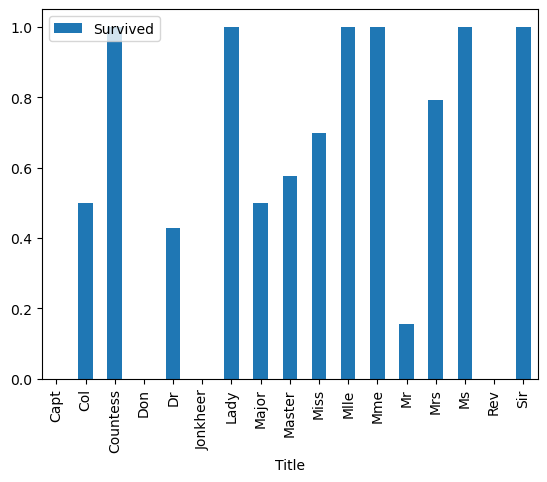

In [19]:
train_data["Title"] = train_data["Name"].str.extract(" ([A-Za-z]+)\.", expand=False)
pd.crosstab(train_data['Title'], train_data['Survived'])
train_data[['Title', 'Survived']].groupby(['Title']).mean().plot.bar()

## Name length with survived

<Axes: xlabel='Name_length', ylabel='Survived'>

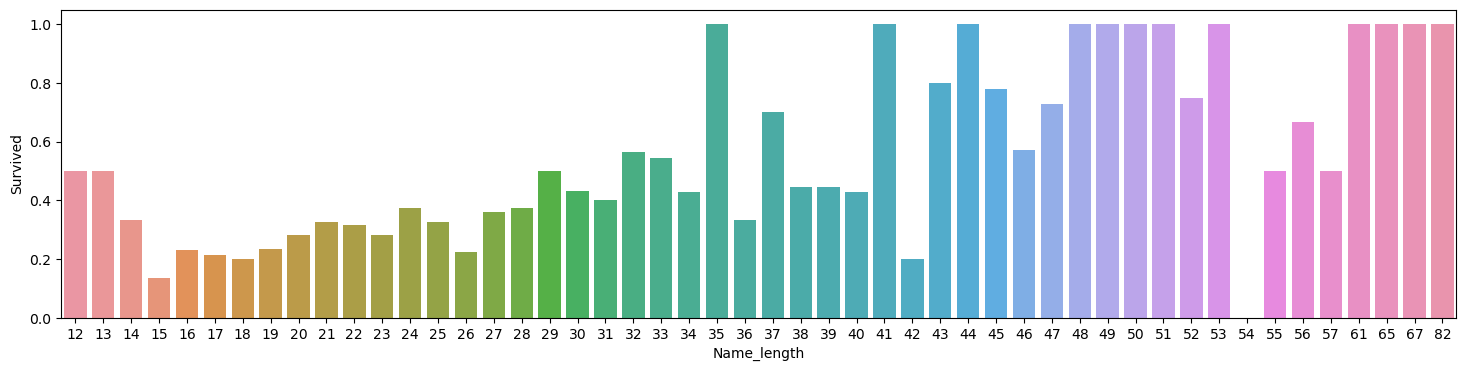

In [20]:
fig, axis1 = plt.subplots(1, 1, figsize=(18, 4))
train_data["Name_length"] = train_data["Name"].apply(len)
name_length = train_data[["Name_length", "Survived"]].groupby(["Name_length"], as_index=False).mean()
sns.barplot(x='Name_length', y='Survived', data=name_length)

## Have cousin or not

In [21]:
sibsp_data = train_data[train_data['SibSp'] != 0]
no_sibsp_data = train_data[train_data['SibSp'] == 0]
sibsp_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_int,Age_group,Title,Name_length
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,S,22,"(18, 65]",Mr,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38,"(18, 65]",Mrs,51
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35,"(18, 65]",Mrs,44
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,U0,S,2,"(0, 12]",Master,30
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,U0,C,14,"(12, 18]",Mrs,35


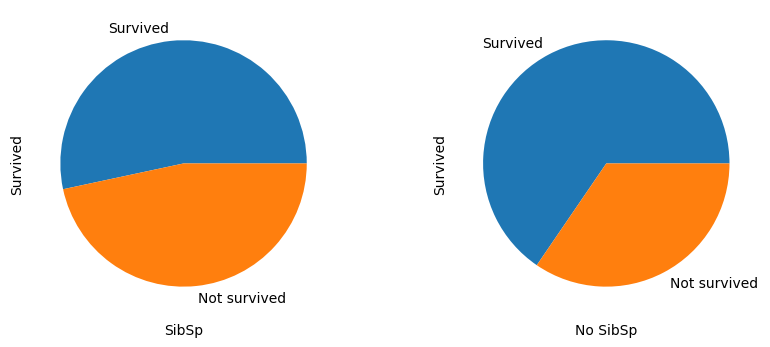

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(121)
sibsp_data['Survived'].value_counts().plot.pie(labels=['Survived', 'Not survived'])
plt.xlabel('SibSp')

plt.subplot(122)
no_sibsp_data['Survived'].value_counts().plot.pie(labels=['Survived', 'Not survived'])
plt.xlabel('No SibSp')

plt.show()

## no. of parch and SibSp with Survived

Text(0.5, 1.0, 'Parch and Survived')

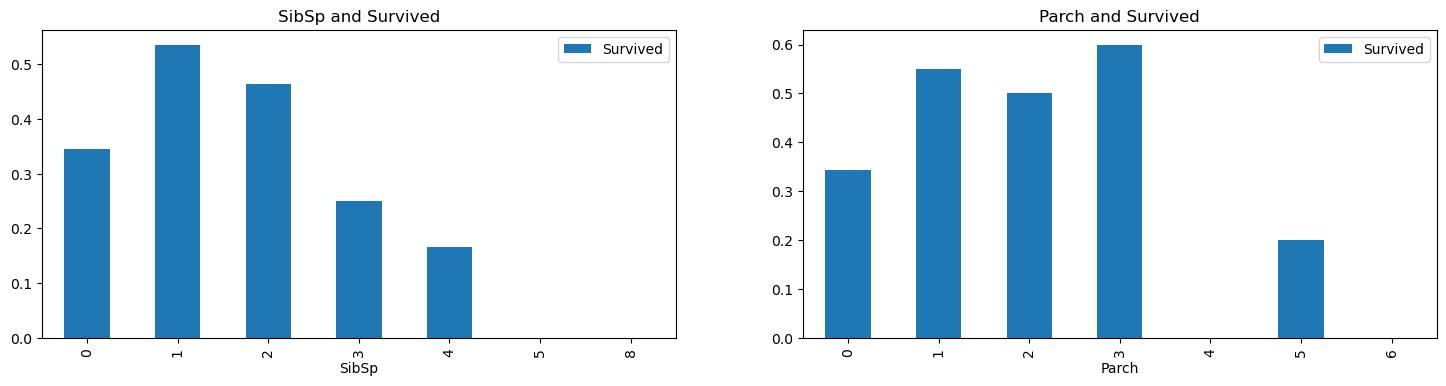

In [23]:
fig, ax = plt.subplots(1,2, figsize=(18,4))
train_data[['SibSp', 'Survived']].groupby('SibSp').mean().plot.bar(ax=ax[0])
ax[0].set_title('SibSp and Survived')

train_data[['Parch', 'Survived']].groupby('Parch').mean().plot.bar(ax = ax[1])
ax[1].set_title('Parch and Survived')

## Combine to family size

<Axes: xlabel='Family_Size'>

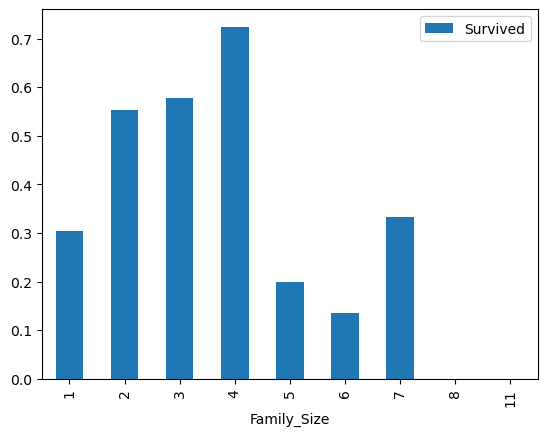

In [24]:
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch'] + 1
train_data[['Family_Size', 'Survived']].groupby('Family_Size').mean().plot.bar()

## Ticket prices distribution

<Axes: >

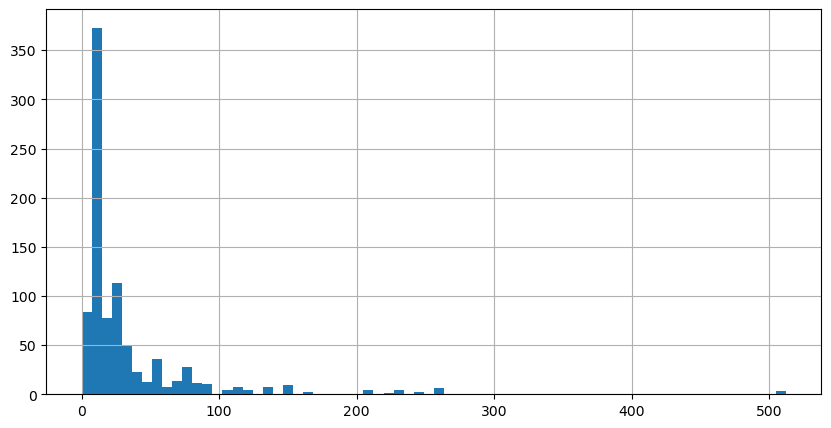

In [25]:
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins=70)

## Ticket price and pclass

<Figure size 1000x500 with 0 Axes>

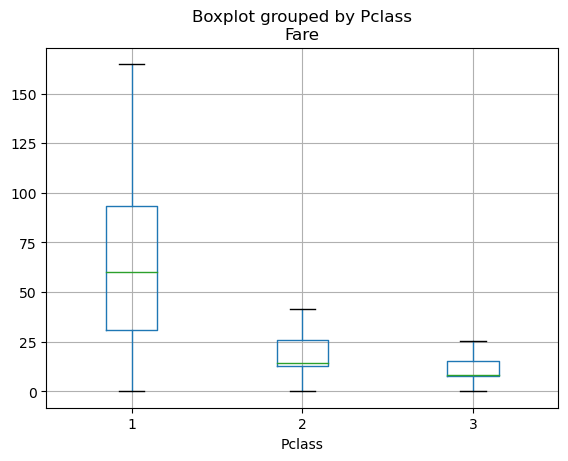

In [26]:
plt.figure(figsize=(10, 5))
train_data.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

## ticket price with Survived

<Axes: >

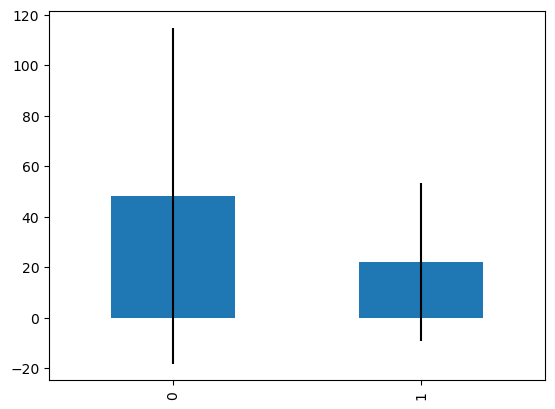

In [27]:
fare_survived = train_data['Fare'][train_data['Survived'] == 1]
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]

average_fare = pd.DataFrame([fare_survived.mean(), fare_not_survived.mean()])
std_fare = pd.DataFrame([fare_survived.std(), fare_not_survived.std()])
average_fare.plot.bar(yerr=std_fare, legend=False)

Text(0.5, 1.0, 'Embarked and Survived')

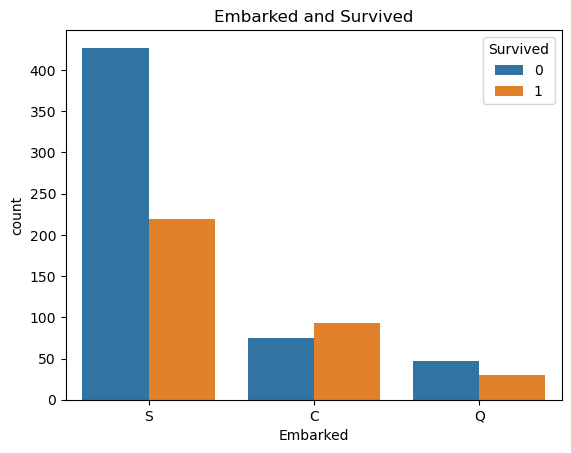

In [28]:
sns.countplot(x='Embarked', hue='Survived', data=train_data)
plt.title("Embarked and Survived")

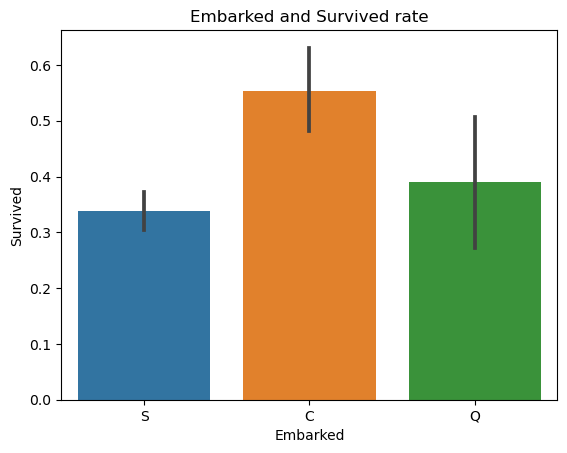

In [29]:
sns.barplot(x="Embarked", y="Survived", data=train_data)
plt.title("Embarked and Survived rate")
plt.show()

# Variables transformation
The scikit-learn requires numeric variables, we need to transform
+ Quantitative variables can be sorted in some way, and Age is a good example. 
+ Qualitative variables describe a certain (nonmathematically representable) aspect of an object, Embarked being an example.

### For Qualitative variables
1. Dummy variables
+ It is a categorical variable or a binary variable. When the qualitative variable is a few independent variables that appear frequently, Dummy Variables are more suitable for use
2. Factorize
+ Dummy is not good at handling the nominal attribute of Cabin because he has more variables. So Pandas has a method called factorize(), which can create numbers to represent categorical variables, mapping an ID to each category, and this mapping only generates one feature at the end, instead of multiple features like dummy.

### For Quantitative variables
1. Scaling
+ Scaling can map a large range of values to a small range (usually [-1, -1], or [0, -1]), in many cases we need to Scaling to make the range the same size, otherwise the large range of values will be weighted higher. For example, the range of Age may be only 0-100, while the range of income may be 0-100000000, which will affect the result in some models that are sensitive to array size.
2. Binning
+ Binning discretizes continuous data by observing "neighbors" (i.e., surrounding values). The stored values are distributed into some "bucket" or "bin", just as the bin of a histogram divides the data into several pieces.

In [30]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_int,Age_group,Title,Name_length,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,S,22,"(18, 65]",Mr,23,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38,"(18, 65]",Mrs,51,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,S,26,"(18, 65]",Miss,22,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35,"(18, 65]",Mrs,44,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,S,35,"(18, 65]",Mr,24,1


## Use Dummy variables to transform 'Embarked'

In [31]:
embarked_dummies = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embarked_dummies)
train_data.drop(['Embarked'], axis=1, inplace=True)

In [32]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_int,Age_group,Title,Name_length,Family_Size,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,22,"(18, 65]",Mr,23,2,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,38,"(18, 65]",Mrs,51,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,26,"(18, 65]",Miss,22,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,35,"(18, 65]",Mrs,44,2,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,35,"(18, 65]",Mr,24,1,0,0,1


## Use Factorizing to transform 'Cabin'

In [33]:
# create feature for the alphabetical part of the cabin number
# "([a-zA-Z]+)"是一个正则表达式，表示匹配一个或多个连续的大小写字母。
# search(x)方法在船舱号中查找匹配的部分，然后group()方法提取出匹配的字符串，即船舱号中的字母部分。
# 这样，train_data['CabinLetter']列将存储每个样本船舱号中的字母部分。
train_data['CabinLetter'] = train_data['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
# Factorize() 返回值是一个元组，其中包含两个数组。第一个数组是将字母映射为整数值的结果，也就是每个不同字母对应的整数值。
# 第二个数组是所有不同字母的列表。然后，将第一个数组的值存储回 train_data['CabinLetter'] 列中，以替代之前的字母部分。
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]

In [34]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_int,Age_group,Title,Name_length,Family_Size,C,Q,S,CabinLetter
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,22,"(18, 65]",Mr,23,2,0,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,38,"(18, 65]",Mrs,51,2,1,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,26,"(18, 65]",Miss,22,1,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,35,"(18, 65]",Mrs,44,2,0,0,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,35,"(18, 65]",Mr,24,1,0,0,1,0


## Use Scaling to transform 'Age'

In [35]:
from sklearn import preprocessing

#test
assert np.size(train_data['Age']) == 891

# Use the StandardScaler to substract mean and divide by standard diviation == Normalize
scaler = preprocessing.StandardScaler()
train_data["Normalized_Age"] = scaler.fit_transform(train_data['Age'].values.reshape(-1, 1))
train_data["Normalized_Age"].head()

0   -0.552762
1    0.604177
2   -0.263527
3    0.387251
4    0.387251
Name: Normalized_Age, dtype: float64

## Use Binning and Factorize to transform 'Fare'

In [36]:
# Divide all fares into 5 quartiles
train_data['Fare_bin'] = pd.qcut(train_data['Fare'], 5)
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64, right]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

In [37]:
# qcut() creates a new variable that identifies the quartile range, but we can't use the string
# so either factorize or create dummies from the result

train_data["Fare_bin_id"] = pd.factorize(train_data["Fare_bin"])[0]

In [38]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title,Name_length,Family_Size,C,Q,S,CabinLetter,Normalized_Age,Fare_bin,Fare_bin_id
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,Mr,23,2,0,0,1,0,-0.552762,"(-0.001, 7.854]",0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,Mrs,51,2,1,0,0,1,0.604177,"(39.688, 512.329]",1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,Miss,22,1,0,0,1,0,-0.263527,"(7.854, 10.5]",2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,Mrs,44,2,0,0,1,1,0.387251,"(39.688, 512.329]",1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,Mr,24,1,0,0,1,0,0.387251,"(7.854, 10.5]",2
